## Rolling Beta 

Comparing the bootstrap beta to the rolling beta

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from   tqdm import tqdm

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from SignalRollingBetaOLS import RollingBetaOLS
from SignalBootstrapBetaOLS import BootstrapBetaOLS

In [3]:
def get_data() -> pd.DataFrame:
    
    df_rolling = (RollingBetaOLS().get_proportion().query(
        "prop == 0.15")
        [["lag_beta", "input_val", "variable", "security"]].
        rename(columns = {"lag_beta": "beta"}).
        assign(ols = "rolling"))

    df_bootstrap = (BootstrapBetaOLS().sample_betas().drop(
        columns = ["sim"]).
        assign(ols = "bootstrap"))

    df_out = (pd.concat([df_rolling, df_bootstrap]))
    
    return df_out

df = get_data()

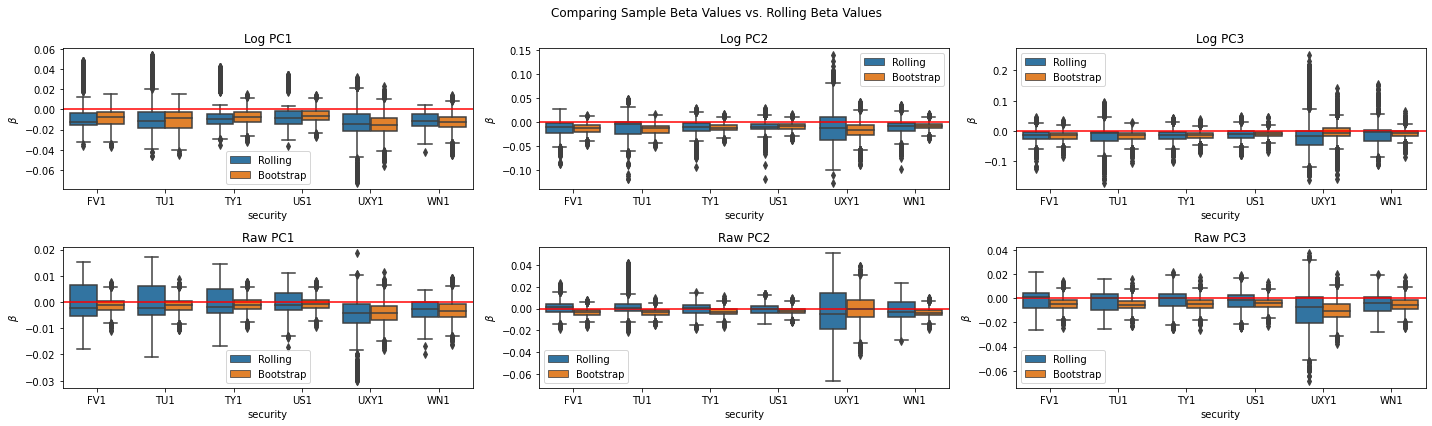

In [4]:
def plot_boxplot(df: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df.assign(
        group_var = lambda x: x.input_val.str.split("_").str[0].str.capitalize() + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,6))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        df_plot = (df_tmp.query(
            "group_var == @group_var").
            assign(ols = lambda x: x.ols.str.capitalize()).
            rename(columns = {"ols": ""}))

        (sns.boxplot(
            data = df_plot,
            x    = "security",
            y    = "beta",
            hue  = "",
            ax   = ax))

        ax.axhline(y = 0, color = "red")
        ax.set_ylabel(r"$\beta$")
        ax.set_title(group_var)

    fig.suptitle("Comparing Sample Beta Values vs. Rolling Beta Values")
    plt.tight_layout()
    
plot_boxplot(df)

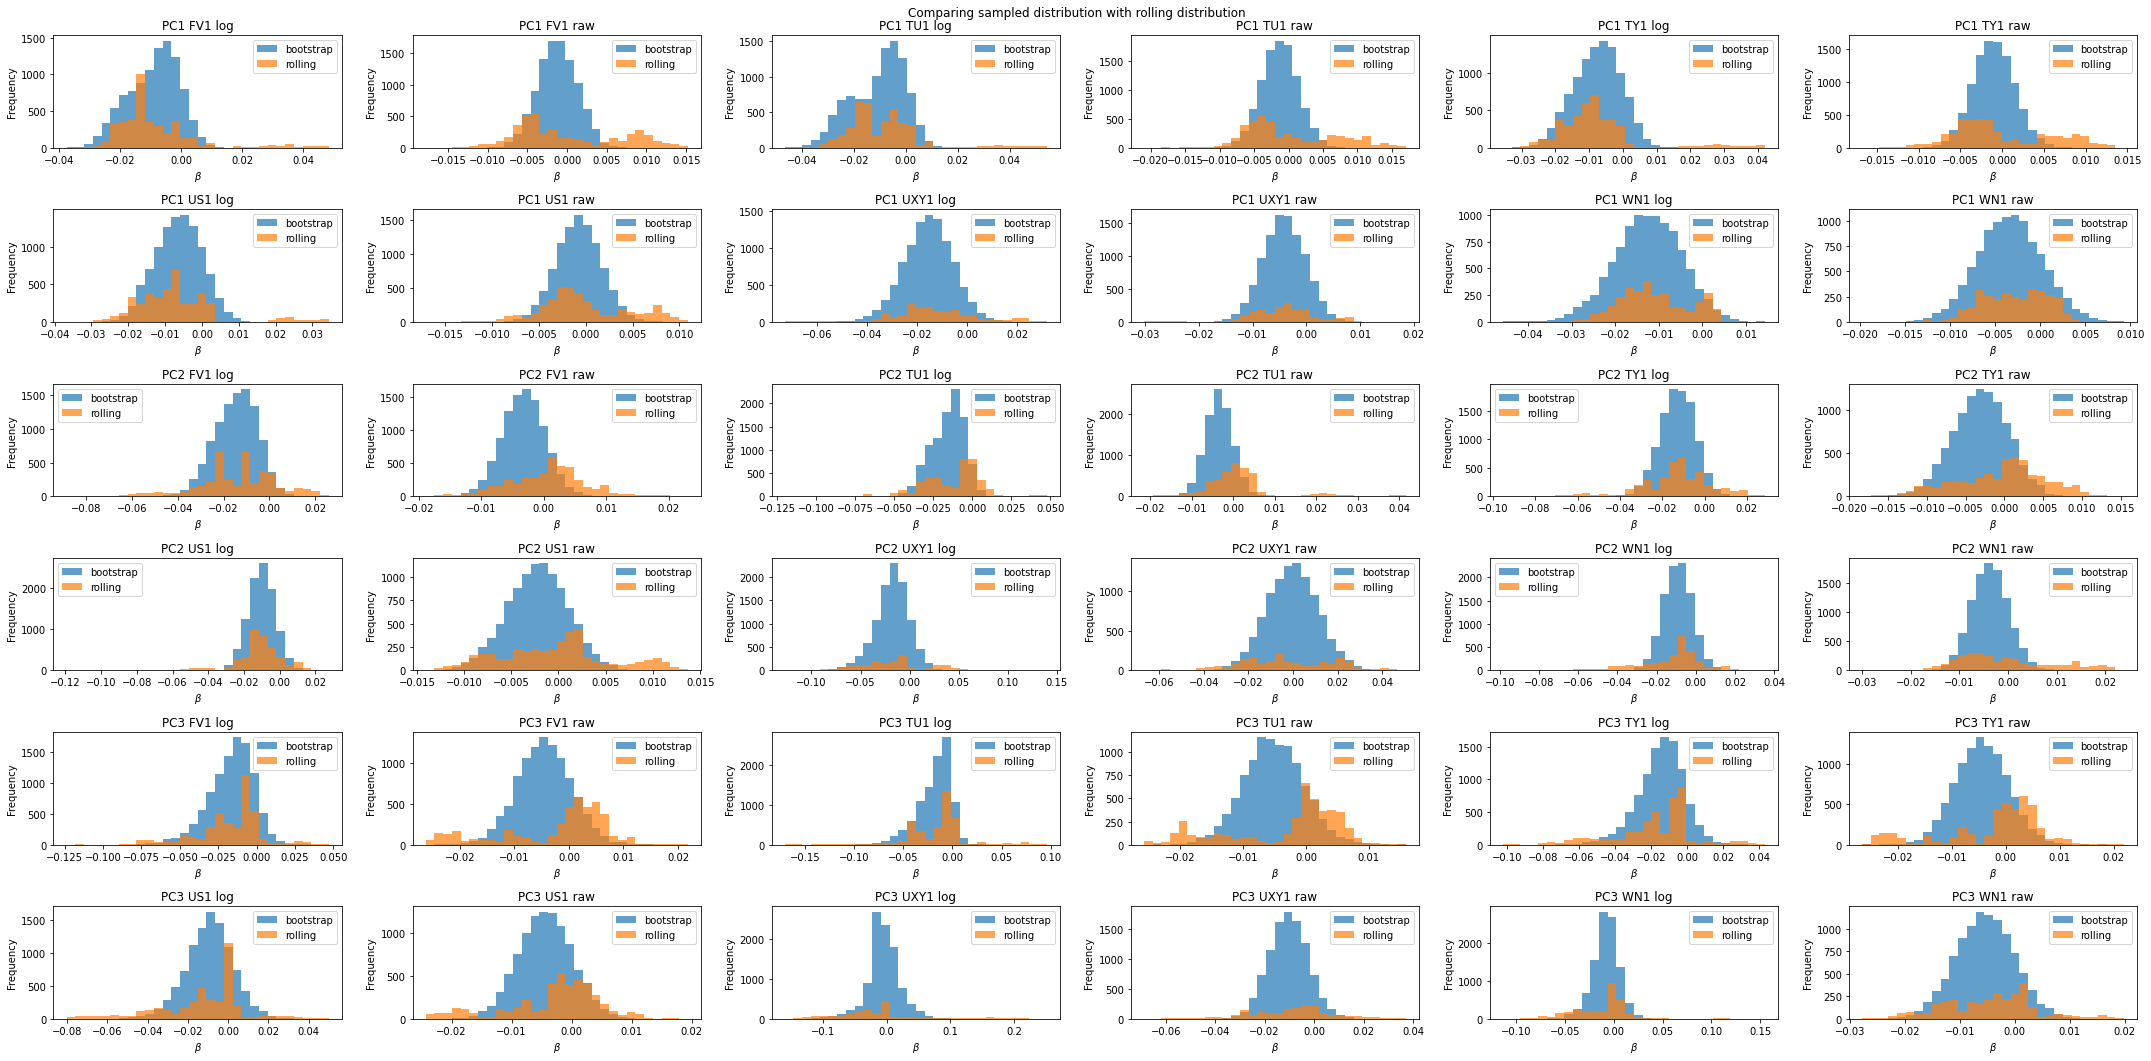

In [5]:
def plot_beta_distribution(df: pd.DataFrame) -> plt.Figure:
    
    df_tmp = (df.assign(
        group_var = lambda x: x.variable + " " + x.security + " " + x.input_val))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 6, nrows = len(group_vars) // 6, figsize = (30,15))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "group_var == @group_var").
            reset_index().
            rename(columns = {"ols": ""}).
            pivot(index = "index", columns = "", values = "beta").
            plot(
                kind   = "hist",
                bins   = 30,
                alpha  = 0.7,
                xlabel = r"$\beta$",
                title  = group_var.split("_")[0],
                ax     = ax))

    fig.suptitle("Comparing sampled distribution with rolling distribution")
    plt.tight_layout()
    
plot_beta_distribution(df)

In [6]:
def get_pos_proportion(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_pos = (df.assign(
        beta_sign = lambda x: np.where(x.beta > 0, "pos", "neg")).
        groupby(["input_val", "variable", "security", "ols", "beta_sign"]).
        agg("count").
        reset_index().
        pivot(index = ["input_val", "variable", "security", "ols"], columns = "beta_sign", values = "beta").
        reset_index().
        assign(
            input_val      = lambda x: x.input_val.str.split("_").str[0].str.capitalize(),
            pos_proportion = lambda x: x.pos / (x.pos + x.neg)).
        pivot(index = ["input_val", "variable", "security"], columns = "ols", values = "pos_proportion").
        reset_index())
    
    return df_pos

df_pos = get_pos_proportion(df)

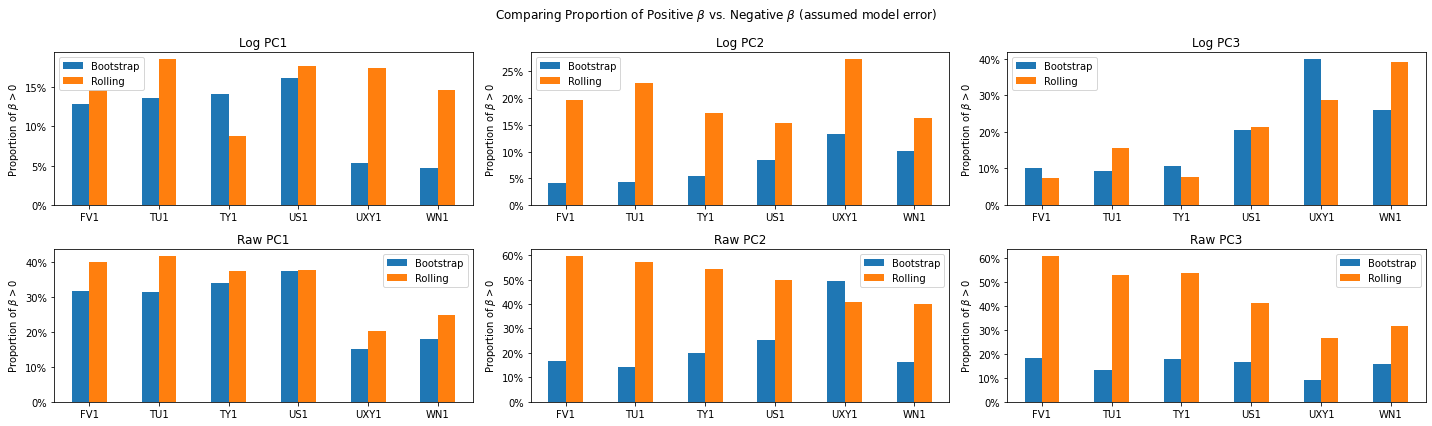

In [7]:
def plot_pos(df_pos: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_pos.assign(
        group_var = lambda x: x.input_val + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,6))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "group_var == @group_var")
            [["security", "rolling", "bootstrap"]].
            melt(id_vars = "security").
            assign(ols = lambda x: x.ols.str.capitalize()).
            rename(columns = {"ols": ""}).
            pivot(index = "security", columns = "", values = "value").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                rot    = 0,
                title  = group_var,
                ylabel = r"Proportion of $\beta > 0$"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle(r"Comparing Proportion of Positive $\beta$ vs. Negative $\beta$ (assumed model error)")
    plt.tight_layout()
    
plot_pos(df_pos)

In [8]:
def get_sign_sharpe() -> pd.DataFrame: 
    
    df_out = (RollingBetaOLS().get_proportion().query(
        "prop == 0.15").
        assign(
            signal_bps = lambda x: np.sign(x.lag_beta * x.lag_spread) * x.PX_bps,
            beta_sign  = lambda x: np.where(x.lag_beta > 0, "Positive", "Negative"))
        [["group_var", "beta_sign", "signal_bps"]].
        groupby(["group_var", "beta_sign"]).
        agg(["mean", "std"])
        ["signal_bps"].
        reset_index().
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(
            sharpe    = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252),
            security  = lambda x: x.group_var.str.split(" ").str[0],
            pc        = lambda x: x.group_var.str.split(" ").str[1],
            input_val = lambda x: x.group_var.str.split(" ").str[-1].str.split("_").str[0]))
    
    return df_out

df_sign_sharpe = get_sign_sharpe()

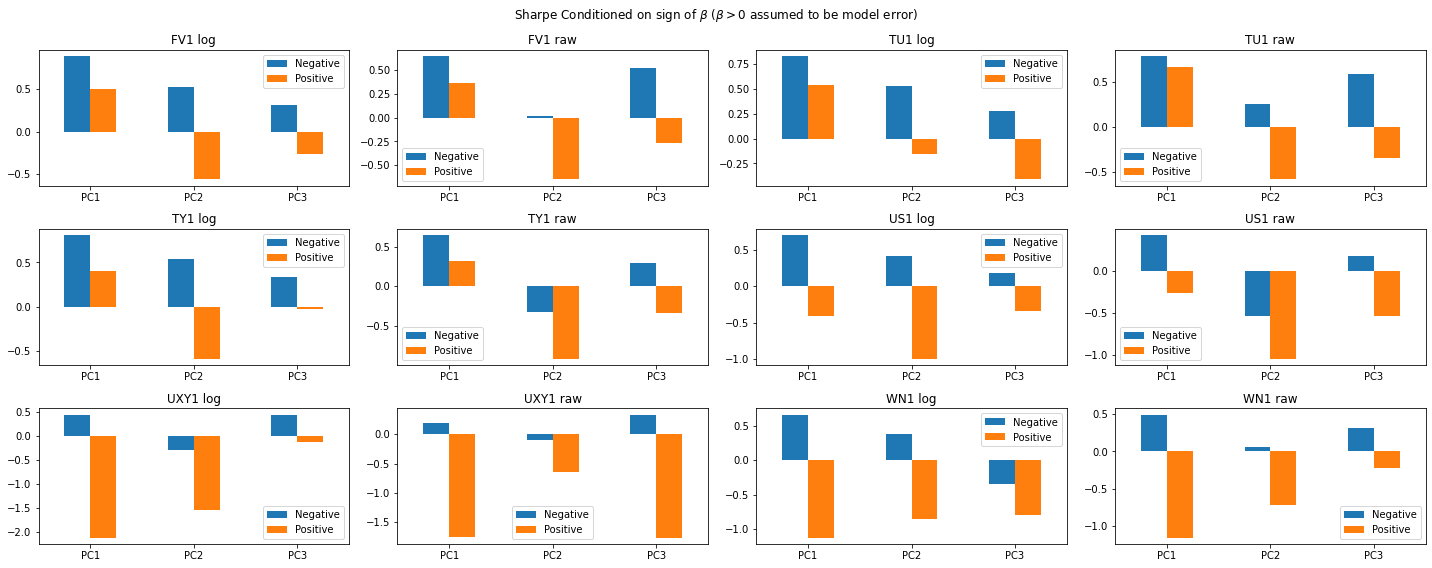

In [9]:
def plot_sharpe_conditioned_beta(df_sign_sharpe: pd.DataFrame) -> plt.Figure:
    
    df_tmp = (df_sign_sharpe.assign(
        group_var = lambda x: x.security + " " + x.input_val))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 3, nrows = len(group_vars) // 4, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "group_var == @group_var").
            rename(columns = {"beta_sign": ""}).
            pivot(index = "pc", columns = "", values = "sharpe").
            plot(
                title  = group_var,
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                rot    = 0))

    fig.suptitle(r"Sharpe Conditioned on sign of $\beta$ ($\beta > 0$ assumed to be model error)")
    plt.tight_layout()
    
plot_sharpe_conditioned_beta(df_sign_sharpe)